# Arbitrarily high order accurate explicit time integration methods

## ADER (Arbitrary Derivative)



In [8]:
# We need a couple of packages in this chapter
import numpy as np  
# This is the basic package in python with all the numerical functions

import matplotlib.pyplot as plt 
# This package allows to  plot

from nodepy import rk
#This package already implemented some functions for Runge Kutta and multistep methods

#from timeit import timeit
import timeit
import csv
from tabulate import tabulate
import time

from distutils.dir_util import mkpath

For the definition of the basis functions in time, we introduce different Lagrange polynomials and point distributions:
1. equispaced
1. Gauss--Legendre--Lobatto (GLB)
1. Gauss--Legendre

So, we have the quadrature points $\lbrace t^m \rbrace_{m=0}^M$, the polynomials $\lbrace \varphi_m \rbrace_{m=0}^M$ such that $\varphi_j(t^m)=\delta_{j}^m$, and we are interested in solving
$$
\frac{d u}{dt} =G(u,t), \qquad u(t=0)=y_0.
$$
The ADER approach reads
$$
\int_{t^n}^{t^{n+1}} \varphi_i(t) \partial_t \varphi_j(t) dt u^j -\int_{t^n}^{t^{n+1}} \varphi_i(t)  \varphi_j(t) dt G(u^j,t^j)
$$
and, using integration by parts, we have
$$
\varphi_i(t^{n+1})\varphi_j(t^{n+1})u^j -  \int_{t^n}^{t^{n+1}} \partial_t\varphi_i(t)  \varphi_j(t) dt u^j  - \varphi_i(t^n) u(t^n)-\int_{t^n}^{t^{n+1}} \varphi_i(t)  \varphi_j(t) dt G(u^j,t^j).
$$

We solve this equation iteratively using the following matrices

$$
\underline{\underline{M}}_{ij} = \varphi_i(t^{n+1})\varphi_j(t^{n+1}) -  \int_{t^n}^{t^{n+1}} \partial_t\varphi_i(t)  \varphi_j(t) dt ,\qquad \underline{\underline{R}}_{ij} = \varphi_i(t^n) u(t^n)-\int_{t^n}^{t^{n+1}} \varphi_i(t)  \varphi_j(t) dt,
$$

with the iterations

$$
\underline{u}^{(k)} = u(t^n) +\underline{\underline{M}}^{-1}\underline{\underline{R}}G(\underline{u}^{(k-1)})
$$

Note that $\underline{\underline{M}}^{-1}_{ji} \varphi_i = 1_j$.

The efficient versions of ADER is done increasing at each iteration the number of subtimenodes starting from 1 (M=0) for GLG and 2 for two times for GLB and equispaced. The increase stop when the maximum order is reached. Then it continues with the classical ADER iterations. The matrices must be modified accordingly and there are three ways to obtain it:
* $L^2$ projection (denoted with ADER_L2 )
$$ 
\underline{\underline{M}}_{ij}^{(k)} =  \phi_i^{new}(1)\phi_j^{new}(1)-\int_0^1 \partial_t\phi^{new}_i \phi^{new}_j, \qquad \underline{\underline{R}}_{ij}^{(k)} =\int_0^1 \phi^{new}_i \phi^{old}_j,
$$
* interpolation of $u$ (denoted with ADER_u )
$$ 
???
$$
* interpolation of $G(u)$ (denoted with ADER_du)
$$ 
\underline{\underline{M}}_{ij}^{(k)} =  \phi_i^{new}(1)\phi_j^{new}(1)-\int_0^1 \partial_t\phi^{new}_i \phi^{new}_j, \qquad \underline{\underline{R}}_{ij}^{(k)} =\int_0^1 \phi^{new}_i \phi^{new}_k dt \,\phi_j^{old}(x_k^{new}).
$$

#### ADER_L2 and ADER_du coincide.

We have that the $new$ polynomials interpolates exactly the $old$ polynomials, i.e.,
$$
\phi_j^{old}(x) = \phi_k^{new}(x) \phi_j^{old}(x_k^{new})
$$
hence, we have that
$$
\underline{\underline{R}}_{ij}^{(k)} =
\int_0^1 \phi^{new}_i \phi^{new}_k dt \,\phi_j^{old}(x_k^{new}) = \\
 \phi^{new}_i(x_z^{quad}) \phi^{new}_k (x_z^{quad}) w_z^{quad} \phi_j^{old}(x_k^{new}) = \\
 \phi^{new}_i(x_z^{quad}) w_z^{quad} \phi_j^{old}(x_z^{quad}) = \int_{0}^1 \phi^{new}_i \phi_j^{old} dt.
$$

In [9]:
from src.DeC import *
from src.ODEproblems import ODEproblem
from src.ADER import ADER, ADER_L2, ADER_u, ClassicalADER
from src.utils import *
table_folder = "tables/"
mkpath(table_folder)
figure_folder = "figures/"
mkpath(figure_folder)

[]

## Testing order of accuracy for different iterations and nodes

In [10]:
ader_method = ADER(6, 6, "orthogonal")
#print(ader_method.RHSmat)
#print(ader_method.bADER)
print(ader_method.evolMat)
print(ader_method.ADERmat)
print(np.linalg.inv(ader_method.ADERmat))
print(ader_method.bADER)
ader_method.compute_RK()
ader_method.evol_un
ader_method.M_sub
ader_method.recon_ADER.shape

[[ 5.00000000e-01 -1.66666667e-01 -2.96736492e-67  3.34888327e-66
  -5.34125686e-66  3.69571813e-66  8.78796534e-67]
 [ 5.00000000e-01  1.18694597e-66 -1.00000000e-01  1.78041895e-66
   9.72636280e-67  2.29296380e-66 -2.24264310e-66]
 [ 8.90209476e-67  1.66666667e-01  3.38279601e-66 -7.14285714e-02
   3.26410141e-66 -7.41841230e-67 -4.24561442e-66]
 [ 1.81009260e-65  6.72602715e-66  1.00000000e-01  4.45104738e-67
  -5.55555556e-02  4.18128693e-67 -1.77471248e-66]
 [ 3.02671222e-65  4.79723995e-66  6.20179268e-66  7.14285714e-02
  -2.39037730e-66 -4.54545455e-02 -2.87891462e-66]
 [ 1.32270291e-64  4.67359975e-66  2.70030208e-66 -9.53795867e-68
   5.55555556e-02 -6.37983458e-66 -3.84615385e-02]
 [-1.81825286e-64 -2.29228940e-65 -2.40653295e-65 -9.88768382e-66
  -1.12100453e-66  4.54545455e-02  3.84615385e-02]]
[[ 1.  1.  1.  1.  1.  1.  1.]
 [-1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1.  1.]
 [-1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1.  1.  1.]
 [-1.  1. -1.  1. -1.  1.

(7, 1)

In [4]:
ader_method = ADER_L2(3, 4, "orthogonal")
#print(ader_method.RHSmat)
#print(ader_method.bADER)
ader_method.evolMats

[array([], dtype=float64),
 array([], shape=(2, 0), dtype=float64),
 array([[ 5.00000000e-01, -1.66666667e-01],
        [ 5.00000000e-01,  0.00000000e+00],
        [ 1.18694597e-65,  1.66666667e-01]]),
 array([[ 5.00000000e-01, -1.66666667e-01,  4.15431089e-66],
        [ 5.00000000e-01,  2.17606761e-66, -1.00000000e-01],
        [ 1.48368246e-65,  1.66666667e-01, -2.13650274e-66],
        [-1.42433516e-65, -1.12759867e-65,  1.00000000e-01]]),
 array([[ 5.00000000e-01, -1.66666667e-01,  4.15431089e-66,
          2.71301936e-66],
        [ 5.00000000e-01,  2.17606761e-66, -1.00000000e-01,
          7.63036694e-67],
        [ 1.48368246e-65,  1.66666667e-01, -2.13650274e-66,
         -7.14285714e-02],
        [-1.42433516e-65, -1.12759867e-65,  1.00000000e-01,
          7.14285714e-02]])]

#### ADER classic

In [4]:
for nodes_type in ["gaussLegendre","gaussLobatto","equispaced"]:
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")

    maxIter=13
    maxSteps = 7

    orders=np.zeros((maxIter+1,maxSteps+1),dtype=np.int64)
    for iit, iterations in enumerate(range(1,maxIter+1)):
        for ist, steps in enumerate(range(1,maxSteps+1)):
            ader_method = ADER(steps, iterations, nodes_type) 
            A,b,c = ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            orders[iit+1,ist+1]=ADERRK.order()
            orders[iit+1,0] = iterations
            orders[0,ist+1] = steps

    print("Order Exact")
    zz=["Iters"]
    [zz.append(orders[0,j]) for j in range(1,maxSteps+1)]

    tab=tabulate(orders[1:,:],headers=zz, tablefmt="grid")
    print("          |        Subtimesteps")
    print(tab)
    print("")
    with open(table_folder+"orders_ADER_"+nodes_type+".tex",'w') as file:
        header = "K\\textbackslash M "
        for M in range(1,maxSteps+1):
            header += f" & {M} "
        file.write(header+"\\\\ \n")        
        for iit, iterations in enumerate(range(1,maxIter+1)):
            line = f"{iterations}"
            for ist, steps in enumerate(range(1,maxSteps+1)):
                line+= f" & {orders[iit+1,ist+1]}"
            line += "\\\\ \n"
            file.write(line)

==================orthogonal======================
Order Exact
          |        Subtimesteps
+---------+-----+-----+-----+-----+-----+-----+-----+
|   Iters |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
+=========+=====+=====+=====+=====+=====+=====+=====+
|       1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       2 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       3 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       4 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       5 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       6 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       7 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+

KeyboardInterrupt: 

#### L2 optimized ADER

In [20]:
for nodes_type in ["gaussLegendre","gaussLobatto","equispaced"]:
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")

    maxIter=13
    maxSteps = 7

    orders=np.zeros((maxIter+1,maxSteps+1),dtype=np.int64)
    for iit, iterations in enumerate(range(1,maxIter+1)):
        for ist, steps in enumerate(range(1,maxSteps+1)):
            ader_method = ADER_L2(steps, iterations, nodes_type) 
            A,b,c = ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            orders[iit+1,ist+1]=ADERRK.order()
            orders[iit+1,0] = iterations
            orders[0,ist+1] = steps

    print("Order Exact")
    zz=["Iters"]
    [zz.append(orders[0,j]) for j in range(1,maxSteps+1)]

    tab=tabulate(orders[1:,:],headers=zz, tablefmt="grid")
    print("          |        Subtimesteps")
    print(tab)
    print("")
    with open(table_folder+"orders_ADER_L2_"+nodes_type+".tex",'w') as file:
        header = "K\\textbackslash M "
        for M in range(1,maxSteps+1):
            header += f" & {M} "
        file.write(header+"\\\\ \n")        
        for iit, iterations in enumerate(range(1,maxIter+1)):
            line = f"{iterations}"
            for ist, steps in enumerate(range(1,maxSteps+1)):
                line+= f" & {orders[iit+1,ist+1]}"
            line += "\\\\ \n"
            file.write(line)

==================gaussLegendre======================
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
Order Exact
          |        Subtimesteps
+---------+-----+-----+-----+-----+-----+-----+-----+
|   Iters |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
+=========+=====+=====+=====+=====+=====+=====+=====+
|       1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       2 |   2 |   2 |   2 |   2 |   2 |   2 |   2 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       3 |   3 |   3 |   3 |   3 |   3 |   3 |   3 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       4 |   3 |   4 |   4 |   4 |   4 |   4 |   4 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       5 |   3 |   5 |   5 |   5 |   5 |   5 |   5 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       6 |   3 |   5 |   6 | 

### ADER u optimized

In [21]:
for nodes_type in ["gaussLegendre","gaussLobatto","equispaced"]:
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")

    maxIter=13
    maxSteps = 7

    orders=np.zeros((maxIter+1,maxSteps+1),dtype=np.int64)
    for iit, iterations in enumerate(range(1,maxIter+1)):
        for ist, steps in enumerate(range(1,maxSteps+1)):
            ader_method = ADER_u(steps, iterations, nodes_type) 
            A,b,c = ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            orders[iit+1,ist+1]=ADERRK.order()
            orders[iit+1,0] = iterations
            orders[0,ist+1] = steps

    print("Order Exact")
    zz=["Iters"]
    [zz.append(orders[0,j]) for j in range(1,maxSteps+1)]

    tab=tabulate(orders[1:,:],headers=zz, tablefmt="grid")
    print("          |        Subtimesteps")
    print(tab)
    print("")
    with open(table_folder+"orders_ADER_u_"+nodes_type+".tex",'w') as file:
        header = "K\\textbackslash M "
        for M in range(1,maxSteps+1):
            header += f" & {M} "
        file.write(header+"\\\\ \n")        
        for iit, iterations in enumerate(range(1,maxIter+1)):
            line = f"{iterations}"
            for ist, steps in enumerate(range(1,maxSteps+1)):
                line+= f" & {orders[iit+1,ist+1]}"
            line += "\\\\ \n"
            file.write(line)

==================gaussLegendre======================
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
Order Exact
          |        Subtimesteps
+---------+-----+-----+-----+-----+-----+-----+-----+
|   Iters |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
+=========+=====+=====+=====+=====+=====+=====+=====+
|       1 |   1 |   1 |   1 |   1 |   1 |   1 |   1 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       2 |   2 |   2 |   2 |   2 |   2 |   2 |   2 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       3 |   3 |   3 |   3 |   3 |   3 |   3 |   3 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       4 |   3 |   4 |   4 |   4 |   4 |   4 |   4 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       5 |   3 |   5 |   5 |   5 |   5 |   5 |   5 |
+---------+-----+-----+-----+-----+-----+-----+-----+
|       6 |   3 |   5 |   6 | 

In [16]:
ader_method = ADER(2, 3, "gaussLegendre") 
A,b,c = ader_method.compute_RK()
ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
print(ADERRK.order())
print(b.flatten())
#print(ader_method.n_subNodess)
#print(ader_method.evolMats)
#b =np.array([0.5,0.5,0.,0.,0.])
print(A)
c.T


3
[0.         0.         0.         0.         0.27777778 0.44444444
 0.27777778]
[[ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.11270167  0.          0.          0.          0.          0.
   0.        ]
 [ 0.5         0.          0.          0.          0.          0.
   0.        ]
 [ 0.88729833  0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.16111111 -0.08042111  0.03201167  0.          0.
   0.        ]
 [ 0.          0.27248542  0.27777778 -0.05026319  0.          0.
   0.        ]
 [ 0.          0.29021056  0.43597667  0.16111111  0.          0.
   0.        ]]


array([[0.        , 0.11270167, 0.5       , 0.88729833, 0.11270167,
        0.5       , 0.88729833]])

### Checking the order of the optimal iterations-nodes version of ADER

In [ ]:

nodes_types=["gaussLegendre","gaussLobatto","equispaced"]
methods = [ADER, ADER_u, ADER_L2]

maxIter=15
data = np.zeros((len(nodes_types), maxIter, len(methods),4),dtype=np.int32)

print("===========================================")
print("= Compare order and stages of L2 ADER     =")
print("===========================================")


for ino, nodes_type in enumerate(nodes_types):
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")


    for i in range(1,maxIter):
        #print("Iters = %d"%i)
        for im, method in enumerate(methods):
            ader_method = method(-1,i,nodes_type)
            #print("Method = "+ader_method.name)
            A,b,c=ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            data[ino, i, im,0] = i
            data[ino, i, im,1] = ader_method.M_sub
            #data[ino, i, im,2] = ADERRK.order()
            data[ino, i, im,2] = ader_method.NRK

    for im, method in enumerate(methods): 
        ader_method = method(-1,1,nodes_type)  
        
        print("Method = "+ader_method.name)

        tab=tabulate(data[ino,:,im,:],headers=["Iters", "Msub", "order","NRK"], tablefmt="grid")
        print(tab)
        print("")
        
    with open(table_folder+"NRK_ADERs_"+nodes_type+".tex",'w') as file:
        header = "$K$ & $M$ "#& Order "
        for im, method in enumerate(methods):
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s $N_{{RK}}$ "%(ader_method.name)
        header += "\\\\ \\hline \n "
        file.write(header)
        for i in range(1,maxIter):
            line = f"{i} & {data[ino, i, 0, 1]} "# & {data[ino, i, 0, 2]}"
            for im, method in enumerate(methods):
                line  += f" & {data[ino,i,im,2]} "
            line += "\\\\ \\hline \n"
            file.write(line)

= Compare order and stages of L2 ADER     =
==================gaussLegendre======================
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
This routine only goes up to order 13.  Use oc_butcher_high_order for higher orders.
Method = ADER_gaussLegendre
+---------+--------+---------+-------+
|   Iters |   Msub |   order |   NRK |
+=========+========+=========+=======+
|       0 |      0 |       0 |     0 |
+---------+--------+---------+-------+
|       1 |      0 |       1 |     1 |
+---------+--------+---------+-------+
|       2 |      1 |       2 |     3 |
+---------+--------+---------+-------+
|       3 |  

KeyboardInterrupt: 

In [13]:

nodes_types=["gaussLegendre","gaussLobatto"]#,"equispaced"]
methods = [ClassicalADER, ADER, ADER_u, ADER_L2]

maxIter=15
data = np.zeros((len(nodes_types), maxIter, len(methods),3),dtype=np.int32)

print("===========================================")
print("= Compare order and stages of L2 ADER     =")
print("===========================================")


for ino, nodes_type in enumerate(nodes_types):
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")


    for i in range(1,maxIter):
        #print("Iters = %d"%i)
        for im, method in enumerate(methods):
            ader_method = method(-1,i,nodes_type)
            #print("Method = "+ader_method.name)
            A,b,c=ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            data[ino, i, im,0] = i
            data[ino, i, im,1] = ader_method.M_sub
            #data[ino, i, im,2] = ADERRK.order()
            data[ino, i, im,2] = ader_method.NRK

    for im, method in enumerate(methods): 
        ader_method = method(-1,1,nodes_type)  
        
        print("Method = "+ader_method.name)

        tab=tabulate(data[ino,:,im,:],headers=["Iters", "Msub", "order","NRK"], tablefmt="grid")
        print(tab)
        print("")
        
    with open(table_folder+"NRK_ADERs_"+nodes_type+"_speed_ups.tex",'w') as file:
        header = "$P$ & $M$"
        for im, method in enumerate(methods):
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s $N_{{RK}}$ "%(ader_method.name)

        for method in methods[2:]:
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s Classical speed-up "%(ader_method.name)

        for method in methods[2:]:
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s speed-up "%(ader_method.name)
        header += "\\\\ \\hline \n "
        file.write(header)
        for i in range(1,maxIter):
            line = f"{i} & {data[ino, i, 1, 1]}"# & {data[ino, i, 1, 2]}"
            for im, method in enumerate(methods):
                line  += f" & {data[ino,i,im,2]} "
            for im, method in enumerate(methods[2:]):
                line += " & %1.3f"%(data[ino,i,0,2]/data[ino,i,im+2,2])
            for im, method in enumerate(methods[2:]):
                line += " & %1.3f"%(data[ino,i,1,2]/data[ino,i,im+2,2])
            line += "\\\\ \\hline \n"
            file.write(line)

= Compare order and stages of L2 ADER     =
==================gaussLegendre======================
Method = ClassicalADER_gaussLegendre
+---------+--------+---------+-------+
|   Iters |   Msub |   order |   NRK |
+=========+========+=========+=======+
|       0 |      0 |       0 |     0 |
+---------+--------+---------+-------+
|       1 |      0 |       1 |     0 |
+---------+--------+---------+-------+
|       2 |      1 |       3 |     0 |
+---------+--------+---------+-------+
|       3 |      2 |       7 |     0 |
+---------+--------+---------+-------+
|       4 |      3 |      13 |     0 |
+---------+--------+---------+-------+
|       5 |      4 |      21 |     0 |
+---------+--------+---------+-------+
|       6 |      5 |      31 |     0 |
+---------+--------+---------+-------+
|       7 |      6 |      43 |     0 |
+---------+--------+---------+-------+
|       8 |      7 |      57 |     0 |
+---------+--------+---------+-------+
|       9 |      8 |      73 |     0 |
+------

In [14]:

nodes_types=["equispaced"]
methods = [ADER, ADER_u, ADER_L2]

maxIter=15
data = np.zeros((len(nodes_types), maxIter, len(methods),3),dtype=np.int32)

print("===========================================")
print("= Compare order and stages of L2 ADER     =")
print("===========================================")


for ino, nodes_type in enumerate(nodes_types):
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")


    for i in range(1,maxIter):
        #print("Iters = %d"%i)
        for im, method in enumerate(methods):
            ader_method = method(-1,i,nodes_type)
            #print("Method = "+ader_method.name)
            A,b,c=ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            data[ino, i, im,0] = i
            data[ino, i, im,1] = ader_method.M_sub
            #data[ino, i, im,2] = ADERRK.order()
            data[ino, i, im,2] = ader_method.NRK

    for im, method in enumerate(methods): 
        ader_method = method(-1,1,nodes_type)  
        
        print("Method = "+ader_method.name)

        tab=tabulate(data[ino,:,im,:],headers=["Iters", "Msub", "order","NRK"], tablefmt="grid")
        print(tab)
        print("")
        
    with open(table_folder+"NRK_ADERs_"+nodes_type+"_speed_ups.tex",'w') as file:
        header = "$P$ & $M$"
        for im, method in enumerate(methods):
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s $N_{{RK}}$ "%(ader_method.name)

        for method in methods[1:]:
            ader_method = method(-1,1,nodes_type) 
            header+= " & %s speed-up "%(ader_method.name)
        header += "\\\\ \\hline \n "
        file.write(header)
        for i in range(1,maxIter):
            line = f"{i} & {data[ino, i, 1, 1]}"# & {data[ino, i, 1, 2]}"
            for im, method in enumerate(methods):
                line  += f" & {data[ino,i,im,2]} "
            for im, method in enumerate(methods[1:]):
                line += " & %1.3f"%(data[ino,i,0,2]/data[ino,i,im+1,2])
            line += "\\\\ \\hline \n"
            file.write(line)

= Compare order and stages of L2 ADER     =
==================equispaced======================
M_steps=0 is not enough to run with equispaced, I run with M_steps=1
M_steps=0 is not enough to run with equispaced, I run with M_steps=1
M_steps=0 is not enough to run with equispaced, I run with M_steps=1
M_steps=0 is not enough to run with equispaced, I run with M_steps=1
Method = ADER_equispaced
+---------+--------+---------+
|   Iters |   Msub |   order |
+=========+========+=========+
|       0 |      0 |       0 |
+---------+--------+---------+
|       1 |      1 |       1 |
+---------+--------+---------+
|       2 |      1 |       2 |
+---------+--------+---------+
|       3 |      2 |       6 |
+---------+--------+---------+
|       4 |      3 |      12 |
+---------+--------+---------+
|       5 |      4 |      20 |
+---------+--------+---------+
|       6 |      5 |      30 |
+---------+--------+---------+
|       7 |      6 |      42 |
+---------+--------+---------+
|       8 |    

## Stability regions

In [ ]:

nodes_types=["gaussLegendre","gaussLobatto","equispaced"]
methods = [ADER, ADER_L2]

maxIter=15
data = np.zeros((len(nodes_types), maxIter, len(methods),4),dtype=np.int32)

print("===========================================")
print("= Compare order and stages of L2 ADER     =")
print("===========================================")


for ino, nodes_type in enumerate(nodes_types):
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")

    
    for im, method in enumerate(methods):
        for i in range(1,maxIter):
            #p1=plt.figure()
            #print("Iters = %d"%i)
            ader_method = method(-1,i,nodes_type)
            #print("Method = "+ader_method.name)
            A,b,c=ader_method.compute_RK()
            ADERRK=rk.ExplicitRungeKuttaMethod(A,b.flatten())
            p1=ADERRK.plot_stability_region(bounds=[-25,5,-10,10])
            plt.title(ader_method.name+str(i))
            plt.show()
            if i<=6:
                p,d = ADERRK.stability_function()
                print(p)

### Study of $L^2$ operator of ADER as IMPLICIT RK

In [18]:
maxSteps = 8
nodes_types=["gaussLegendre","gaussLobatto","equispaced"]
for ino, nodes_type in enumerate(nodes_types):
    print("=====================================================")
    print(f"=================={nodes_type}======================")
    print("=====================================================")
    for i in range(0,maxSteps):
        ader_method = ADER(i,2,nodes_type)
        A=ader_method.evolMat
        b=ader_method.bADER.flatten()
        ADERRK=rk.RungeKuttaMethod(A,b)
        print(ADERRK)
        print(f"M = {i}, order = {ADERRK.order()}")

==================gaussLegendre======================
Runge-Kutta Method

 1.000 | 1.000
_______|_______
       | 1.000
M = 0, order = 1
Runge-Kutta Method

 0.211 | 0.333 -0.122
 0.789 | 0.455  0.333
_______|______________
       | 0.500  0.500
M = 1, order = 3
Runge-Kutta Method

 0.113 | 0.161 -0.080  0.032
 0.500 | 0.272  0.278 -0.050
 0.887 | 0.290  0.436  0.161
_______|_____________________
       | 0.278  0.444  0.278
M = 2, order = 5
Runge-Kutta Method

 0.069 | 0.095 -0.047  0.033 -0.012
 0.330 | 0.177  0.191 -0.056  0.018
 0.670 | 0.178  0.326  0.191 -0.025
 0.931 | 0.169  0.334  0.332  0.095
_______|____________________________
       | 0.174  0.326  0.326  0.174
M = 3, order = 7
Runge-Kutta Method

 0.047 | 0.063 -0.030  0.024 -0.016  0.005
 0.231 | 0.123  0.134 -0.043  0.025 -0.008
 0.500 | 0.119  0.245  0.162 -0.036  0.010
 0.769 | 0.116  0.243  0.291  0.134 -0.015
 0.953 | 0.120  0.235  0.286  0.249  0.063
_______|___________________________________
       | 0.118  0.239

Runge-Kutta Method

 0.000 | 0.003 -0.022  0.067 -0.111  0.111 -0.067  0.022 -0.003
 0.143 | 0.044  0.161 -0.131  0.124 -0.083  0.036 -0.009  0.001
 0.286 | 0.042  0.224 -0.030  0.102 -0.083  0.041 -0.012  0.001
 0.429 | 0.042  0.218  0.038  0.198 -0.106  0.049 -0.014  0.002
 0.571 | 0.043  0.215  0.044  0.250  0.004  0.021 -0.006  0.001
 0.714 | 0.042  0.220  0.032  0.262  0.064  0.110 -0.018  0.002
 0.857 | 0.042  0.218  0.034  0.267  0.038  0.214  0.044 -0.000
 1.000 | 0.043  0.207  0.077  0.173  0.173  0.077  0.207  0.043
_______|________________________________________________________
       | 0.043  0.207  0.077  0.173  0.173  0.077  0.207  0.043
M = 7, order = 8


# ADER in small problem

In [5]:
from src.utils import compute_integral_error

0.0032514960269860367


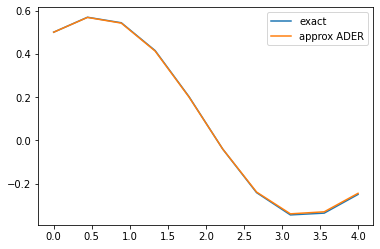

In [6]:
order=3
ADER_method=ADER_u(-1,order,"equispaced")
pr=ODEproblem("vibratingDamped")

tt=np.linspace(0,pr.T_fin,10)   #Plot the evolution for order 8
tt,uu=ADER_method.ader(pr.flux, tt, pr.u0)

u_ex = pr.exact_solution_times(pr.u0,tt)
    

plt.plot(tt,u_ex[1,:],label="exact")
plt.plot(tt,uu[0,:],label="approx ADER")
print(compute_integral_error(uu,u_ex))

plt.legend()



order= 3
dt is  1.0
ADER_gaussLobatto
time =  0.0004520416259765625
ADER_L2_gaussLobatto
time =  0.0003566741943359375
ADER_u_gaussLobatto
time =  0.0004820823669433594
dt is  0.5
ADER_gaussLobatto
time =  0.0006861686706542969
ADER_L2_gaussLobatto
time =  0.000736236572265625
ADER_u_gaussLobatto
time =  0.0008301734924316406
dt is  0.25
ADER_gaussLobatto
time =  0.0013918876647949219
ADER_L2_gaussLobatto
time =  0.0012443065643310547
ADER_u_gaussLobatto
time =  0.0013720989227294922
dt is  0.125
ADER_gaussLobatto
time =  0.002885103225708008
ADER_L2_gaussLobatto
time =  0.00292205810546875
ADER_u_gaussLobatto
time =  0.003473997116088867
dt is  0.0625
ADER_gaussLobatto
time =  0.005434751510620117
ADER_L2_gaussLobatto
time =  0.0043299198150634766
ADER_u_gaussLobatto
time =  0.005318403244018555
dt is  0.03125
ADER_gaussLobatto
time =  0.01089930534362793
ADER_L2_gaussLobatto
time =  0.00869607925415039
ADER_u_gaussLobatto
time =  0.010664224624633789
order= 4
dt is  1.0
ADER_gaussLob

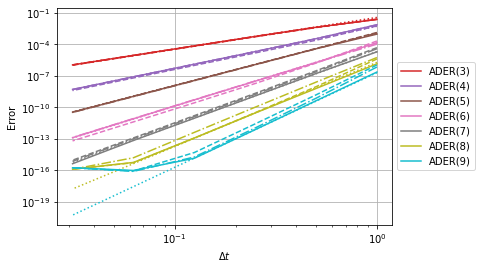

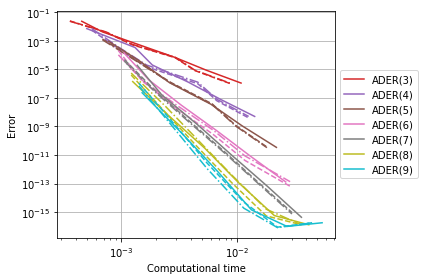

In [7]:
#Test convergence of DeC for several orders
pr=ODEproblem("vibratingDamped")

import time

long_version=False

tt=np.linspace(0,pr.T_fin,10)   #Plot the evolution for order 8
#dec8 = DeC_staggered(7, 8, "equispaced")
#tt,uu=dec8.dec(pr.flux, tt, pr.u0)
# plt.plot(tt,uu[0,:])
# plt.plot(tt,uu[1,:])
# plt.show()

colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",\
       "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


NN=6
dts=[pr.T_fin/2.0**k for k in range(2,2+NN)]


methods = [ADER, ADER_L2, ADER_u]#, DeC_staggered_f, DeC_small_sub, DeC_small_sub_staggered, DeC_small_sub_staggered_f]
N_meth = len(methods)

nodes_types = ["gaussLobatto"]

errors=np.zeros((N_meth,len(dts)))
times =np.zeros((N_meth,len(dts)))

for node_type in nodes_types:
    fig1,ax1 = plt.subplots(1,1)
    fig2,ax2 = plt.subplots(1,1)
    #fig3,ax3 = plt.subplots(1,1)
    #fig4,ax4 = plt.subplots(1,1)
    for order in range(3,10):
        print("order=",order)
        for k in range(NN):
            dt0=dts[k]
            print("dt is ",dt0)
            tt=np.arange(0,pr.T_fin,dt0)
            M_sub = -1
            K_iter = order

            for im, method in enumerate(methods):
                # Staggered DeC
                ader_method = method(M_sub, K_iter, node_type)
                print(ader_method.name)
                if long_version:
                    res = %timeit -o ader_method.ader(pr.flux, tt, pr.u0)
                    times[im,k] = res.average
                    t2,U2=ader_method.ader(pr.flux, tt, pr.u0)
                else:
                    tic = time.time()
                    t2,U2=ader_method.ader(pr.flux, tt, pr.u0)
                    toc= time.time()
                    times[im,k] = toc-tic
                print("time = ",times[im,k])
                
                u_exact=pr.exact_solution_times(pr.u0,tt)
                errors[im,k]=compute_integral_error(U2,u_exact)

        ax1.loglog(dts,errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        ax2.loglog(times[0,:],errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        if order ==2:
            ax1.loglog(dts,errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
            ax1.loglog(dts,errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
            ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
            ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
        else:
            ax1.loglog(dts,errors[1,:],"--",color=colors[order])
            ax1.loglog(dts,errors[2,:],"-.",color=colors[order])
            ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order])
            ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order])
        ax1.loglog(dts,[dt**(order)*errors[0,2]/dts[2]**(order) for dt in dts],":",color=colors[order])#,label="ref %d"%(order))

    #ax1.set_title("DeC error convergence")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel("Error")
    ax1.set_xlabel(r"$\Delta t$")
    ax1.grid(True)
    plt.tight_layout()
    fig1.savefig(figure_folder+f"convergence_ADER_{node_type}_{pr.name}.pdf")


    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel("Error")
    ax2.set_xlabel("Computational time")
    ax2.grid(True)
    plt.tight_layout()
    fig2.savefig(figure_folder+f"time_vs_error_ADER_{node_type}_{pr.name}.pdf")


    plt.show()




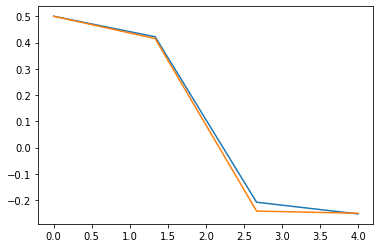

In [6]:
pr=ODEproblem("vibratingDamped")
tt=np.linspace(0,pr.T_fin,4) 
method = ADER(3,4,"orthogonal")
tt,uu = method.ader_orthogonal(pr.flux, tt, pr.u0)
u_exact=pr.exact_solution_times(pr.u0,tt)
plt.plot(tt,uu[0,:])
plt.plot(tt,u_exact[0,:])

order= 3
dt is  1.0
ADER_orthogonal
time =  0.0012328624725341797
dt is  0.5
ADER_orthogonal
time =  0.0027730464935302734
dt is  0.25
ADER_orthogonal
time =  0.005616188049316406
dt is  0.125
ADER_orthogonal
time =  0.011192560195922852
dt is  0.0625
ADER_orthogonal
time =  0.01939249038696289
dt is  0.03125
ADER_orthogonal
time =  0.04498291015625
order= 4
dt is  1.0
ADER_orthogonal
time =  0.001967191696166992
dt is  0.5
ADER_orthogonal
time =  0.0043985843658447266
dt is  0.25
ADER_orthogonal
time =  0.009369850158691406
dt is  0.125
ADER_orthogonal
time =  0.01918768882751465
dt is  0.0625
ADER_orthogonal
time =  0.039286136627197266
dt is  0.03125
ADER_orthogonal
time =  0.07430768013000488
order= 5
dt is  1.0
ADER_orthogonal
time =  0.003243684768676758
dt is  0.5
ADER_orthogonal
time =  0.007550954818725586
dt is  0.25
ADER_orthogonal
time =  0.014547586441040039
dt is  0.125
ADER_orthogonal
time =  0.031328439712524414
dt is  0.0625
ADER_orthogonal
time =  0.06069183349609375


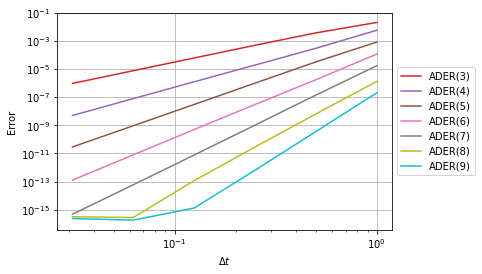

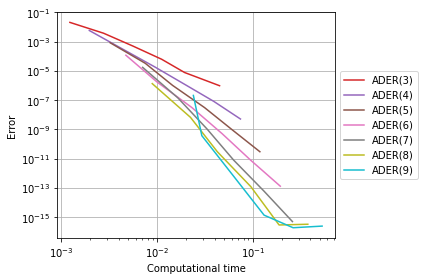

order= 3
dt is  1.0
ADER_gaussLobatto
time =  0.00034546852111816406
dt is  0.5
ADER_gaussLobatto
time =  0.0007615089416503906
dt is  0.25
ADER_gaussLobatto
time =  0.0013523101806640625
dt is  0.125
ADER_gaussLobatto
time =  0.002538442611694336
dt is  0.0625
ADER_gaussLobatto
time =  0.00529170036315918
dt is  0.03125
ADER_gaussLobatto
time =  0.009664297103881836
order= 4
dt is  1.0
ADER_gaussLobatto
time =  0.0006878376007080078
dt is  0.5
ADER_gaussLobatto
time =  0.001157999038696289
dt is  0.25
ADER_gaussLobatto
time =  0.0018954277038574219
dt is  0.125
ADER_gaussLobatto
time =  0.004609346389770508
dt is  0.0625
ADER_gaussLobatto
time =  0.008116483688354492
dt is  0.03125
ADER_gaussLobatto
time =  0.016217470169067383
order= 5
dt is  1.0
ADER_gaussLobatto
time =  0.0008251667022705078
dt is  0.5
ADER_gaussLobatto
time =  0.0015587806701660156
dt is  0.25
ADER_gaussLobatto
time =  0.003275632858276367
dt is  0.125
ADER_gaussLobatto
time =  0.0067598819732666016
dt is  0.0625


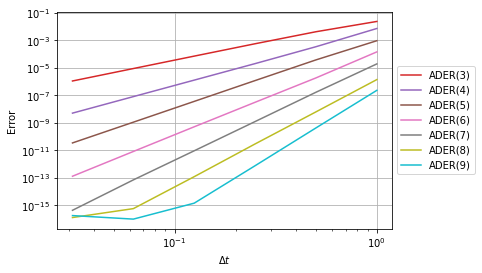

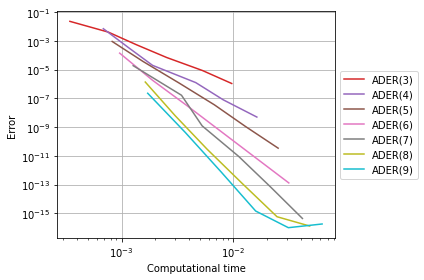

In [8]:
#Test convergence of DeC for several orders
pr=ODEproblem("vibratingDamped")

import time

long_version=False

tt=np.linspace(0,pr.T_fin,10)   #Plot the evolution for order 8
#dec8 = DeC_staggered(7, 8, "equispaced")
#tt,uu=dec8.dec(pr.flux, tt, pr.u0)
# plt.plot(tt,uu[0,:])
# plt.plot(tt,uu[1,:])
# plt.show()

colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",\
       "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


NN=6
dts=[pr.T_fin/2.0**k for k in range(2,2+NN)]


methods = [ADER]#, ADER_L2, ADER_u]#, DeC_staggered_f, DeC_small_sub, DeC_small_sub_staggered, DeC_small_sub_staggered_f]
N_meth = len(methods)

nodes_types = ["orthogonal","gaussLobatto"]

errors=np.zeros((N_meth,len(dts)))
times =np.zeros((N_meth,len(dts)))

for node_type in nodes_types:
    fig1,ax1 = plt.subplots(1,1)
    fig2,ax2 = plt.subplots(1,1)
    #fig3,ax3 = plt.subplots(1,1)
    #fig4,ax4 = plt.subplots(1,1)
    for order in range(3,10):
        print("order=",order)
        for k in range(NN):
            dt0=dts[k]
            print("dt is ",dt0)
            tt=np.arange(0,pr.T_fin,dt0)
            M_sub = -1
            K_iter = order

            for im, method in enumerate(methods):
                # Staggered DeC
                ader_method = method(M_sub, K_iter, node_type)
                print(ader_method.name)
                if long_version:
                    res = %timeit -o ader_method.ader(pr.flux, tt, pr.u0)
                    times[im,k] = res.average
                    t2,U2=ader_method.ader(pr.flux, tt, pr.u0)
                else:
                    tic = time.time()
                    t2,U2=ader_method.ader(pr.flux, tt, pr.u0)
                    toc= time.time()
                    times[im,k] = toc-tic
                print("time = ",times[im,k])
                
                u_exact=pr.exact_solution_times(pr.u0,tt)
                errors[im,k]=compute_integral_error(U2,u_exact)

        ax1.loglog(dts,errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        ax2.loglog(times[0,:],errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        # if order ==2:
        #     ax1.loglog(dts,errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
        #     ax1.loglog(dts,errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
        #     ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
        #     ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
        # else:
        #     ax1.loglog(dts,errors[1,:],"--",color=colors[order])
        #     ax1.loglog(dts,errors[2,:],"-.",color=colors[order])
        #     ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order])
        #     ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order])
        # ax1.loglog(dts,[dt**(order)*errors[0,2]/dts[2]**(order) for dt in dts],":",color=colors[order])#,label="ref %d"%(order))

    #ax1.set_title("DeC error convergence")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel("Error")
    ax1.set_xlabel(r"$\Delta t$")
    ax1.grid(True)
    plt.tight_layout()
    # fig1.savefig(figure_folder+f"convergence_ADER_{node_type}_{pr.name}.pdf")


    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel("Error")
    ax2.set_xlabel("Computational time")
    ax2.grid(True)
    plt.tight_layout()
    # fig2.savefig(figure_folder+f"time_vs_error_ADER_{node_type}_{pr.name}.pdf")


    plt.show()



### nodepy solver

In [54]:
from nodepy import ivp
pr=ODEproblem("linear_system2")
f = lambda t,u : pr.flux(u,t)
u0 = pr.u0
t0 = 0.
T = pr.T_fin
exact = lambda t, u0: pr.exact(u0,t)
myivp = ivp.IVP(f=f, u0=u0, t0=t0, T=T,exact=exact, name = pr.name)

In [74]:
dt0=0.25
ader_method = method(3, 4, "gaussLegendre")
A,b,c = ader_method.compute_RK()
print(ader_method.name)
rk_method = rk.ExplicitRungeKuttaMethod(A,b.flatten())
#res = %timeit -o rk_method(myivp, dt=dt0)
tt,uu=rk_method(myivp, dt=dt0)
uu=np.array(uu).T
print(uu)
u_exact=pr.exact_solution_times(pr.u0,tt)
print(u_exact)

compute_integral_error(uu,u_exact)

ADER_u_gaussLegendre
[[0.9        0.3671875  0.22149658 0.18165922 0.17076619]
 [0.1        0.6328125  0.77850342 0.81834078 0.82923381]]
[[0.9        0.33029545 0.20317718 0.17481326 0.16848442]
 [0.1        0.66970455 0.79682282 0.82518674 0.83151558]]


0.018701322369734

order= 3
dt is  0.25
ADER_gaussLegendre
401 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.00040086921357267
ADER_L2_gaussLegendre
391 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.0003907451497153878
ADER_u_gaussLegendre
393 µs ± 463 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.00039262707900031404
dt is  0.125
ADER_gaussLegendre
760 µs ± 2.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.0007596343019998
ADER_L2_gaussLegendre
792 µs ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.0007916891244292076
ADER_u_gaussLegendre
797 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.000797459063714736
dt is  0.0625
ADER_gaussLegendre
1.56 ms ± 72 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.0015627572822860592
ADER_L2_gaussLegendre
1.5 ms ± 32.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
time =  0.

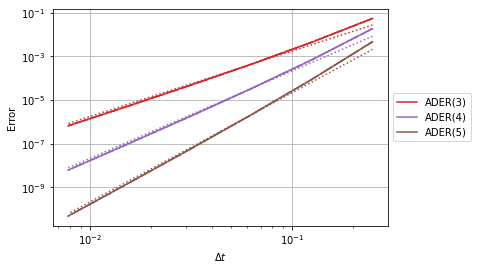

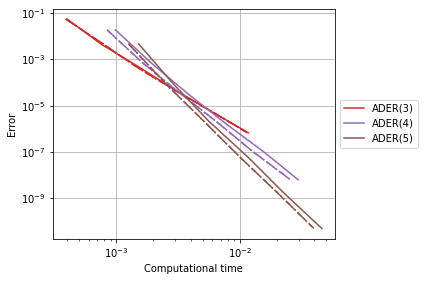

In [77]:
#Test convergence of DeC for several orders
pr=ODEproblem("linear_system2")

tt=np.linspace(0,pr.T_fin,10)   #Plot the evolution for order 8
#dec8 = DeC_staggered(7, 8, "equispaced")
#tt,uu=dec8.dec(pr.flux, tt, pr.u0)
# plt.plot(tt,uu[0,:])
# plt.plot(tt,uu[1,:])
# plt.show()

colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",\
       "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


NN=6
dts=[pr.T_fin/2.0**k for k in range(2,2+NN)]


methods = [ADER, ADER_L2, ADER_u]#, DeC_staggered_f, DeC_small_sub, DeC_small_sub_staggered, DeC_small_sub_staggered_f]
N_meth = len(methods)

nodes_types = ["gaussLegendre"]

errors=np.zeros((N_meth,len(dts)))
times =np.zeros((N_meth,len(dts)))

for node_type in nodes_types:
    fig1,ax1 = plt.subplots(1,1)
    fig2,ax2 = plt.subplots(1,1)
    #fig3,ax3 = plt.subplots(1,1)
    #fig4,ax4 = plt.subplots(1,1)
    for order in range(3,6):
        print("order=",order)
        for k in range(NN):
            dt0=dts[k]
            print("dt is ",dt0)
            tt=np.arange(0,pr.T_fin,dt0)
            M_sub = -1
            K_iter = order

            for im, method in enumerate(methods):
                # Staggered DeC
                ader_method = method(M_sub, K_iter, node_type)
                A,b,c = ader_method.compute_RK()
                print(ader_method.name)
                rk_method = rk.ExplicitRungeKuttaMethod(A,b.flatten())
                res = %timeit -o rk_method(myivp, dt=dt0)
                #res = %timeit -o ader_method.ader(pr.flux, tt, pr.u0)
                times[im,k] = res.average
                print("time = ",times[im,k])
                t2,U2=rk_method(myivp, dt=dt0)
                U2=np.array(U2).T
                #u_exact = [myivp.exact(t,myivp.u0) for t in t2]
                u_exact=pr.exact_solution_times(pr.u0,t2)
                errors[im,k]=compute_integral_error(U2,u_exact)

        ax1.loglog(dts,errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        ax2.loglog(times[0,:],errors[0,:],"-",color=colors[order],label="ADER(%d)"%(K_iter))
        if order ==2:
            ax1.loglog(dts,errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
            ax1.loglog(dts,errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
            ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order],label="ADER_L2(%d)"%(K_iter))
            ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order],label="ADER_u(%d)"%(K_iter))
        else:
            ax1.loglog(dts,errors[1,:],"--",color=colors[order])
            ax1.loglog(dts,errors[2,:],"-.",color=colors[order])
            ax2.loglog(times[1,:],errors[1,:],"--",color=colors[order])
            ax2.loglog(times[1,:],errors[2,:],"-.",color=colors[order])
        ax1.loglog(dts,[dt**(order)*errors[0,2]/dts[2]**(order) for dt in dts],":",color=colors[order])#,label="ref %d"%(order))

    #ax1.set_title("DeC error convergence")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel("Error")
    ax1.set_xlabel(r"$\Delta t$")
    ax1.grid(True)
    plt.tight_layout()
    fig1.savefig(figure_folder+f"convergence_ADER_{node_type}_{pr.name}.pdf")


    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel("Error")
    ax2.set_xlabel("Computational time")
    ax2.grid(True)
    plt.tight_layout()
    fig2.savefig(figure_folder+f"time_vs_error_ADER_{node_type}_{pr.name}.pdf")


    plt.show()



## Adaptive - ADER

0.00030601298176335945
computing structures
computed structures
6.543093958102061e-09


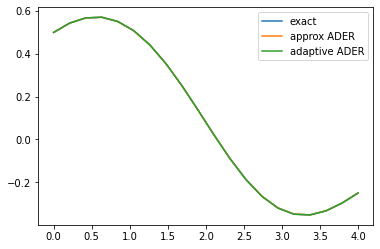

0.00030601298176335945
1.858422314967416e-05
1.8808890231881548e-06
5.19170284823832e-07
6.543093958102061e-09


Text(0.5, 0, 'Time')

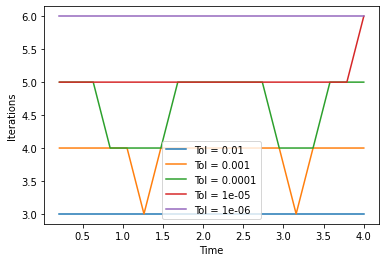

In [6]:
from src.utils import compute_integral_error
order=3
ADER_method=ADER_L2(-1,order,"equispaced")
pr=ODEproblem("vibratingDamped")

tt=np.linspace(0,pr.T_fin,20)   #Plot the evolution for order 8
tt,uu=ADER_method.ader(pr.flux, tt, pr.u0)

u_ex = pr.exact_solution_times(pr.u0,tt)
    

plt.plot(tt,u_ex[1,:],label="exact")
plt.plot(tt,uu[0,:],label="approx ADER")
print(compute_integral_error(uu,u_ex))


print("computing structures")
ADER_method=ADER_L2(-1,10,"equispaced")
print("computed structures")
tt,uu,p=ADER_method.ader_order_control(pr.flux, tt, pr.u0,1e-6)
  
plt.plot(tt,uu[0,:],label="adaptive ADER")
print(compute_integral_error(uu,u_ex))

plt.legend()
plt.show()

plt.figure()



for tol in [1e-2,1e-3,1e-4,1e-5,1e-6]:
    tt,uu,p=ADER_method.ader_order_control(pr.flux, tt, pr.u0,tol)
    print(compute_integral_error(uu,u_ex))
    plt.plot(tt[1:],p[1:],label="Tol = %1.3g"%tol)
plt.legend()
plt.ylabel("Iterations")
plt.xlabel("Time")

0.006200672082386386
computing structures
computed structures
2.3592003524208903e-08


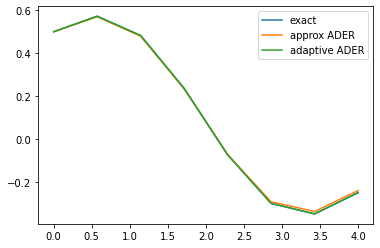

0.000581142816658382
6.418371738890196e-05
4.80337710183223e-06
3.4153307149345904e-07
2.3592003524208903e-08


Text(0.5, 0, 'Time')

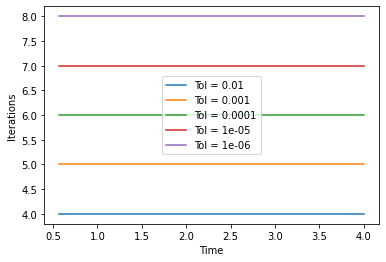

In [4]:
from src.utils import compute_integral_error
order=3
ADER_method=ADER_u(-1,order,"equispaced")
pr=ODEproblem("vibratingDamped")

tt=np.linspace(0,pr.T_fin,8)   #Plot the evolution for order 8
tt,uu=ADER_method.ader(pr.flux, tt, pr.u0)

u_ex = pr.exact_solution_times(pr.u0,tt)
    

plt.plot(tt,u_ex[1,:],label="exact")
plt.plot(tt,uu[0,:],label="approx ADER")
print(compute_integral_error(uu,u_ex))


print("computing structures")
ADER_method=ADER_u(-1,12,"equispaced")
print("computed structures")
tt,uu,p=ADER_method.ader_order_control(pr.flux, tt, pr.u0,1e-6)
  
plt.plot(tt,uu[0,:],label="adaptive ADER")
print(compute_integral_error(uu,u_ex))

plt.legend()
plt.show()

plt.figure()



for tol in [1e-2,1e-3,1e-4,1e-5,1e-6]:
    tt,uu,p=ADER_method.ader_order_control(pr.flux, tt, pr.u0,tol)
    print(compute_integral_error(uu,u_ex))
    plt.plot(tt[1:],p[1:],label="Tol = %1.3g"%tol)
plt.legend()
plt.ylabel("Iterations")
plt.xlabel("Time")

### Damped pendulum

In [10]:
order = 7
ader_method = ADER_u(-1,order,"equispaced")
A,b,c = ader_method.compute_RK()
for k in range(np.shape(A)[0]):
    print(A[k,:])

print(c.T)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.06666667 -0.13333333  0.06666667  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
[ 0.16666667  0.22222222 -0.05555556  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         

In [4]:
pr=ODEproblem("nonLinearOscillatorDamped")
tt=np.linspace(0,pr.T_fin,2)   #Plot the evolution for order 8
node_type = "gaussLobatto"
for order in range(2,10):
    print("========================")
    print("order ",order)
    print("========================")
    print("ADER")
    ader_method=ADER(-1,order,node_type)
    tt,uu=ader_method.ader(pr.flux, tt, pr.u0)
    ader_method.compute_RK()
    print(ader_method.NRK)
    print("ADER L2")
    ader_method=ADER_L2(-1,order,node_type)
    tt,uu=ader_method.ader(pr.flux, tt, pr.u0)
    ader_method.compute_RK()
    print(ader_method.NRK)
    print("ADER u")
    ader_method=ADER_u(-1,order,node_type)
    tt,uu=ader_method.ader(pr.flux, tt, pr.u0)
    ader_method.compute_RK()
    print(ader_method.NRK)

 

order  2
ADER
2
ADER L2
2
ADER u
2
2
order  3
ADER
6
ADER L2
4
ADER u
6
6
order  4
ADER
9
ADER L2
7
ADER u
9
9
order  5
ADER
16
ADER L2
11
ADER u
15
15
order  6
ADER
20
ADER L2
15
ADER u
19
19
order  7
ADER
30
ADER L2
21
ADER u
27
27
order  8
ADER
35
ADER L2
26
ADER u
32
32
order  9
ADER
48
ADER L2
34
ADER u
42
42


In [5]:
order = 3
ADER_3=ADER(-1,order,"gaussLegendre")
tic=time.time()
ADER_ada=ADER_u(-1,16,"gaussLegendre")
print(time.time()-tic)

8.181102514266968


1.068869417975261
8.605572734922168e-06


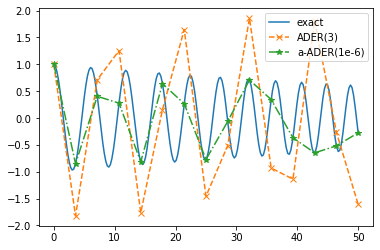

0.02168263929655081
0.02456549438144826
0.00012267339322339204
1.4326994766445017e-05
8.605572734922168e-06


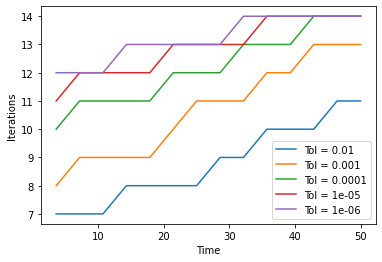

0.21332776699136885
0.02168263929655081
0.02456549438144826
0.00012267339322339204


Text(0.5, 0, 'Time')

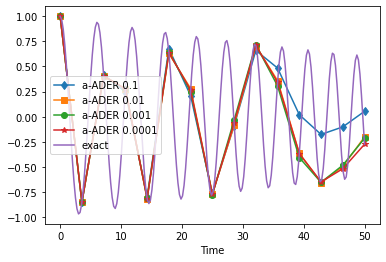

In [6]:

from src.utils import compute_integral_error

pr=ODEproblem("nonLinearOscillatorDamped")

tt=np.linspace(0,pr.T_fin,15)   #Plot the evolution for order 8
tt,uu=ADER_3.ader(pr.flux, tt, pr.u0)

u_ex = pr.exact_solution_times(pr.u0,tt)
   
tt_plot = np.linspace(0,pr.T_fin,200)
u_ex_plot = pr.exact_solution_times(pr.u0,tt_plot)

print(compute_integral_error(uu,u_ex))
plt.plot(tt_plot,u_ex_plot[0,:],label="exact")
plt.plot(tt,uu[0,:],"x--",label="ADER(3)")


tt,uu,p=ADER_ada.ader_order_control(pr.flux, tt, pr.u0,1e-6)
  
plt.plot(tt,uu[0,:],"*-.",label="a-ADER(1e-6)")

print(compute_integral_error(uu,u_ex))
plt.legend()
plt.show()

plt.figure()

for tol in [1e-2,1e-3,1e-4,1e-5,1e-6]:
    tt,uu,p=ADER_ada.ader_order_control(pr.flux, tt, pr.u0,tol)
    plt.plot(tt[1:],p[1:],label="Tol = %1.3g"%tol)
    print(compute_integral_error(uu,u_ex))
   

plt.legend()
plt.ylabel("Iterations")
plt.xlabel("Time")
plt.show()

symbols = ["d","s","o","*","1","2","3","x","+","."]
plt.figure()
for itol, tol in enumerate([1e-1,1e-2,1e-3,1e-4]):
    tt,uu,p=ADER_ada.ader_order_control(pr.flux, tt, pr.u0,tol)
    plt.plot(tt,uu[0,:],marker=symbols[itol],label="a-ADER %1.1g"%tol)
    print(compute_integral_error(uu,u_ex))
    
    
plt.plot(tt_plot,u_ex_plot[0,:],label="exact")
plt.legend()
plt.xlabel("Time")